##Import Libraries

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import time
import csv
import copy
import random
import torch
import torch.nn as nn 
import torch.optim as optim
from tqdm.notebook import tqdm
from random import randrange
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score

##Import Dataset into csv files

Assign HealthyDataset and FaultyDataset csv file path 

In [3]:
healthy_file_path="/content/HealthyDataset.csv"
faulty_file_path="/content/FaultyDataset.csv"

In [4]:
#Create Healthy Dataset List
healthy_dataset=[]
with open(healthy_file_path, 'r') as file:
  csvreader = csv.reader(file)
  start=True
  for row in csvreader:
    if start:
      row[0]=row[0].replace('\ufeff','')              #Eliminate encoding information present at the start
      healthy_dataset.append([float(i) for i in row])
      start=False
      continue
    healthy_dataset.append([float(i) for i in row])
healthy_set=np.array(healthy_dataset)

In [5]:
#Create Faulty Dataset List
faulty_dataset=[]
with open(faulty_file_path, 'r') as file:
  csvreader = csv.reader(file)
  start=True
  for row in csvreader:
    if start:
      row[0]=row[0].replace('\ufeff','')              #Eliminate encoding information present at the start
      faulty_dataset.append([float(i) for i in row])
      start=False
      continue
    faulty_dataset.append([float(i) for i in row])
faulty_set=np.array(faulty_dataset)

##Segregating Train and Private(testing) Data




**Healthy Dataset**<br/><br/>
Total rows/records: 99840
 

*   Training set: Row-1 --> Row-79872
*   Testing set: Row-79873 --> Row-99840<br/><br/>

**Faulty Dataset**<br/><br/>
Total rows/records: 94208
 
*   Training set: Row-1 --> Row-75367
*   Testing set: Row-75368 --> Row-94208

<br/><br/>**Train and Test size**<br/><br/>

Train: 79872 + 75367 = 155239 <br/>
Test:  19968 + 18841 = 38809

In [6]:
len_test_healthy_data=int(len(healthy_set)*0.2)
len_test_faulty_data=int(len(faulty_set)*0.2)
#Using the last 19968 rows of healthy dataset and last 18841 rows of faulty dataset for Testing
#The rest will be used for training purposes
private_healthy_data=healthy_set[-len_test_healthy_data:]
private_faulty_data=faulty_set[-len_test_faulty_data:]
healthy_dataset=healthy_set[:-len_test_healthy_data]
faulty_dataset=faulty_set[:-len_test_faulty_data]
len(private_healthy_data),len(private_faulty_data),len(healthy_dataset),len(faulty_dataset)

(19968, 18841, 79872, 75367)

In [7]:
# Adding class value to each row/record in Private datasets(healthy and faulty)
# Merging both healthy and faulty private datasets with class labels
# Total records in merged Private Dataset = 38809
# Row 1-19968 is for healthy,    Row 19969-38809 is for faulty
 
private_healthy_cls=np.ones((len(private_healthy_data),1))
private_faulty_cls=np.zeros((len(private_faulty_data),1))

priv_data=np.hstack((private_healthy_data,private_healthy_cls))
priv_data=np.concatenate((priv_data,np.hstack((private_faulty_data,private_faulty_cls))),axis=0)

In [8]:
# Adding class value to each row/record in Training datasets(healthy and faulty)
# Merging both healthy and faulty training datasets with class labels
# Total records in merged Private Dataset = 79872(Healthy) + 75367(Faulty) = 155239
# Row 1-79872 is for healthy,    Row 79873-155239 is for faulty

healthy_cls=np.ones((len(healthy_dataset),1))
faulty_cls=np.zeros((len(faulty_dataset),1))

data=np.hstack((healthy_dataset,healthy_cls))
data=np.concatenate((data,np.hstack((faulty_dataset,faulty_cls))),axis=0)

###Data Analysis

In [9]:
healthy_df=pd.DataFrame(healthy_dataset)
faulty_df=pd.DataFrame(faulty_dataset)

In [10]:
healthy_df.describe(),faulty_df.describe()

(                  0             1             2             3
 count  79872.000000  79872.000000  79872.000000  79872.000000
 mean       0.016661     -0.009071      0.024359      0.004745
 std        8.083522      4.600867      4.496546      5.150981
 min      -50.800000    -27.400000    -27.000000    -31.300000
 25%       -4.600000     -2.630000     -2.560000     -2.870000
 50%       -0.241000      0.088450      0.093650      0.216000
 75%        4.470000      2.740000      2.700000      3.030000
 max       49.500000     28.000000     25.100000     33.400000,
                   0             1             2             3
 count  75367.000000  75367.000000  75367.000000  75367.000000
 mean      -0.006239      0.002347     -0.008748      0.006510
 std        4.722098      4.318786      3.875293      4.562771
 min      -24.300000    -28.600000    -18.600000    -27.300000
 25%       -3.000000     -2.480000     -2.150000     -2.500000
 50%       -0.113000      0.148000      0.054300      

##Creating Train and Validation Data through starting point of sample size and starting point

In [11]:
#Defining the size of the sample from the continuous data for training
sample_size=1000

In [12]:
#Creating random starting point for sample selection 
np.random.seed(0)
starting_point_limit_healthy=len(healthy_dataset)-sample_size
starting_point_limit_faulty=len(faulty_dataset)-sample_size
sample_starting_points_healthy=np.arange(starting_point_limit_healthy)
sample_starting_points_faulty=np.arange(starting_point_limit_faulty)
np.random.shuffle(sample_starting_points_healthy)
np.random.shuffle(sample_starting_points_faulty)
sample_starting_points_healthy, sample_starting_points_faulty

(array([63667, 27725, 55309, ..., 42613, 43567, 68268]),
 array([23103, 66646,  6297, ..., 32316, 22958,  3927]))

In [13]:
#Defining the Percentage of data to be used for train, validation and test for training data
len_sample_starting_point_healthy=len(sample_starting_points_healthy)
len_sample_starting_point_faulty=len(sample_starting_points_faulty)
train_data_perc=70
validation_data_perc=15
test_data_perc=15

In [14]:
#Sample starting points for Train, Validation and Test Data for Healthy condition
np.random.seed(0)
train_starting_points_healthy=np.random.choice(sample_starting_points_healthy, size=int(len_sample_starting_point_healthy*train_data_perc*0.01), replace=False)
val_test_starting_points_healthy=np.setdiff1d(sample_starting_points_healthy, train_starting_points_healthy)
validation_starting_points_healthy=np.random.choice(val_test_starting_points_healthy, size=int(len_sample_starting_point_healthy*validation_data_perc*0.01), replace=False)
test_starting_points_healthy=np.setdiff1d(val_test_starting_points_healthy, validation_starting_points_healthy)
train_starting_points_healthy,validation_starting_points_healthy,test_starting_points_healthy

(array([61437, 21233, 73549, ..., 28076, 73563, 78156]),
 array([20442, 45380, 75161, ..., 21238, 41851, 34593]),
 array([    7,    23,    29, ..., 78851, 78854, 78865]))

In [15]:
len(train_starting_points_healthy),len(validation_starting_points_healthy),len(test_starting_points_healthy)

(55210, 11830, 11832)

In [16]:
#Sample starting points for Train, Validation and Test Data for Faulty condition
np.random.seed(0)
train_starting_points_faulty=np.random.choice(sample_starting_points_faulty+len(healthy_dataset), size=int(len_sample_starting_point_faulty*train_data_perc*0.01), replace=False)
val_test_starting_points_faulty=np.setdiff1d(sample_starting_points_faulty+len(healthy_dataset), train_starting_points_faulty)
validation_starting_points_faulty=np.random.choice(val_test_starting_points_faulty, size=int(len_sample_starting_point_faulty*validation_data_perc*0.01), replace=False)
test_starting_points_faulty=np.setdiff1d(val_test_starting_points_faulty, validation_starting_points_faulty)
train_starting_points_faulty,validation_starting_points_faulty,test_starting_points_faulty

(array([119276, 116758,  81919, ..., 109401, 115831, 148189]),
 array([113122, 151408, 147680, ...,  88051, 109663, 130146]),
 array([ 79885,  79900,  79913, ..., 154210, 154214, 154237]))

In [17]:
#Combining the starting sample points for both Healthy and Faulty data, generating Train,Validation and Test
train_starting_points=np.append(train_starting_points_healthy,train_starting_points_faulty)
validation_starting_points=np.append(validation_starting_points_healthy,validation_starting_points_faulty)
test_starting_points=np.append(test_starting_points_healthy,test_starting_points_faulty)

##Model

In [18]:
class LSTM_net(nn.Module):
  def __init__(self,input_size, hidden_size, output_size,num_layers=1):
    super(LSTM_net,self).__init__()
    self.hidden=hidden_size
    self.lstm_cell=nn.LSTM(input_size,hidden_size,num_layers=num_layers,batch_first=True)
    self.h2o=nn.Linear(hidden_size, output_size)
    self.act=nn.Sigmoid()
    self.softmax=nn.LogSoftmax(dim=2)

  def forward(self,input_,hidden_=None,batch_size=1):
    
    out,hidden=self.lstm_cell(input_,hidden_)
    output=self.h2o(hidden[0])
    output=self.act(output)
    return output,hidden

  def init_hidden(self,batch_size=1):
    return torch.zeros(1,batch_size,self.hidden)

In [19]:
def dataloader(nsamples,sample_size,data,start_points):
  start_points=np.random.choice(start_points,size=nsamples)
  input,cls=np.zeros((nsamples,sample_size,4)),np.ones(nsamples)*-1
  for idx,i in enumerate(start_points):
    input[idx]=data[i:i+sample_size,:4]
    cls[idx]=data[i,4]
  return input,cls.flatten()

##Train Setup

In [20]:
def train_a_batch(net,opt,loss_fn,batch_size,sample_size,data,starting_points,device='cpu'):

  net.train().to(device)  #sets the mode to training
  opt.zero_grad()         #resetting all grad values to zero
  
  net=net.double()
  batched_input,target=dataloader(batch_size,sample_size,data,starting_points)
  target=torch.from_numpy(target).double().to(device)
  sample_interval=int(sample_size/150)
  batched_input=batched_input[:,::sample_interval,:]
  batched_input=torch.from_numpy(batched_input).double().to(device)
  batched_output,hidden=net(batched_input)

  loss=loss_fn(batched_output.flatten(),target)

  loss.backward()
  opt.step()

  return loss

In [47]:
def train_setup(net,opt,data,starting_points,priv_data,n_batches=100,batch_size=10,display_frequency=5,device='cpu'):
  
  net=net.to(device)
  loss_fn=nn.BCELoss()
  loss_plot=[]
  acc_plot=[]

  loss_arr=np.zeros(n_batches)
  best_accuracy=0

  for i in tqdm(range(n_batches),desc='Batch Completion'):
    sample_size=randrange(500,1000)
    loss_arr[i]=train_a_batch(net,opt,loss_fn,batch_size,sample_size,data,starting_points,device_gpu).item()
    
    if i%display_frequency==0:
      if i>0:
        avg_loss=sum(loss_arr[i-display_frequency+1:i+1])/display_frequency
        loss_plot.append(avg_loss)
      else:
        loss_plot.append(loss_arr[i])

      if i%(2*display_frequency)==0:
        accuracy,f1,cond_met=test_evaluate(priv_data,1000,net,test_size=1000,device=device)
        acc_plot.append(accuracy)
        #Saving the model if the F-Measure is above 0.95
        if(cond_met==True):
          req_model=copy.deepcopy(net.state_dict())
          print('------MODEL SAVED------')  
          #Saving the model with highest accuracy 
          if accuracy>best_accuracy:
            best_accuracy=accuracy
            most_accurate_model=copy.deepcopy(net.state_dict())
            print("ACCURACY = ",accuracy)
      plt.plot(loss_plot)
      plt.xlabel('Iteration')
      plt.ylabel('Avg Loss in interval')
      plt.show()
    
  
  return loss_arr,loss_plot,acc_plot,most_accurate_model,req_model

###Evaluation

In [22]:
def evaluate(eval_data,sample_size,starting_points,model,device='cpu'):
  working_starting_points=np.random.choice(starting_points,size=1000)
  model=model.to(device_gpu)
  total,correct=0,0
  pred_list=[]
  for i in tqdm(working_starting_points,desc="Evaluation"):
    input=np.zeros((1,sample_size,4))
    print(i)
    input[0]=priv_data[i:i+sample_size,:4]
    sample_interval=int(sample_size/150)
    input=torch.from_numpy(input[:,::sample_interval,:]).double().to(device_gpu)
    cls=eval_data[i,4]
    output,hidden=model(input)
    pred= 0 if output<0.5 else 1
    pred_list.append(pred)
    if pred==cls:
      correct+=1
    total+=1
  return correct/total,pred_list,starting_points

In [48]:
def test_evaluate(priv_data,sample_size,model,test_size=1000,device='cpu'):

  #Setting Up Private Data according to Sample size
  priv_starting_point_limit_healthy=len(private_healthy_data)-sample_size
  priv_starting_point_limit_faulty=len(private_faulty_data)-sample_size
  priv_sample_starting_points_healthy=np.arange(priv_starting_point_limit_healthy)
  priv_sample_starting_points_faulty=np.arange(priv_starting_point_limit_faulty+len(private_healthy_data))
  starting_points=np.append(priv_sample_starting_points_healthy,priv_sample_starting_points_faulty)
  
  working_size=test_size
  #Choosing 'working_size' number of elements from the starting points
  working_starting_points=np.random.choice(starting_points,size=working_size)
  model=model.to(device_gpu)
  total,correct=0,0
  pred_list=[]
  cls_list=[]

  #Prediction and evaluation
  for i in tqdm(working_starting_points,desc="Evaluation"):
    input=np.zeros((1,sample_size,4))
    input[0]=priv_data[i:i+sample_size,:4]
    sample_interval=int(sample_size/150)
    input=torch.from_numpy(input[:,::sample_interval,:]).double().to(device_gpu)
    cls=priv_data[i,4]
    cls_list.append(cls)
    output,hidden=model(input)
    pred= 0 if output<0.5 else 1
    pred_list.append(pred)
    if pred==cls:
      correct+=1
    total+=1

  # y_pred=nn.functional.one_hot(torch.tensor(pred),2)
  # y_true=cls_list

  
  confusion=confusion_matrix(pred_list, cls_list)
  confusion=confusion/confusion.astype(np.float).sum(axis=1)
  df_cm=pd.DataFrame(confusion)
  plt.show()
  target_names = ['Faulty', 'Healthy']
  f1=f1_score(cls_list, pred_list, average=None)
  cond_met=min(f1)>=0.95
  if cond_met:
    print(confusion)
    sns.heatmap(df_cm, annot=True)
    print(classification_report(cls_list, pred_list, target_names=target_names))
  accuracy=correct/total
  return accuracy,f1,cond_met

##Training the model

###Set 1

In [49]:
#Hyperparameter assignments
batch_size=512
input_size=4
hidden_size=32
output_size=1
num_layers=1
n_batches=3000
model=LSTM_net(input_size=input_size,hidden_size=hidden_size,output_size=output_size,num_layers=num_layers)

Batch Completion:   0%|          | 0/3000 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/1000 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:38: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


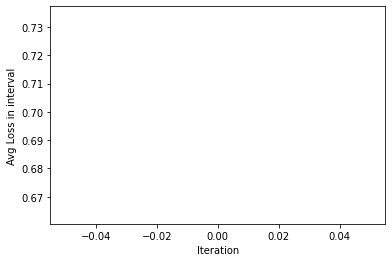

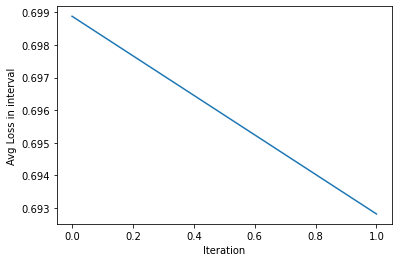

Evaluation:   0%|          | 0/1000 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:38: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


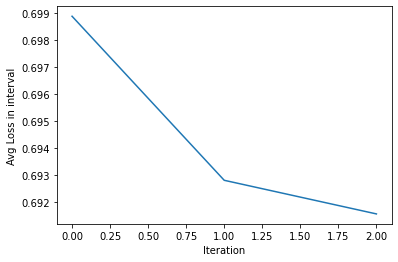

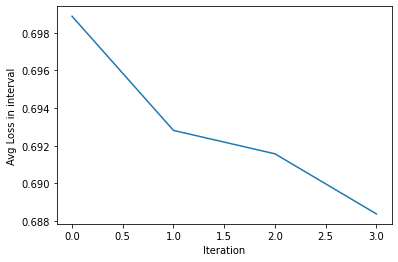

Evaluation:   0%|          | 0/1000 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:38: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


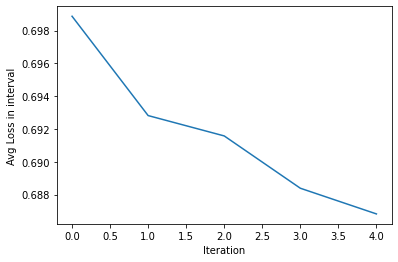

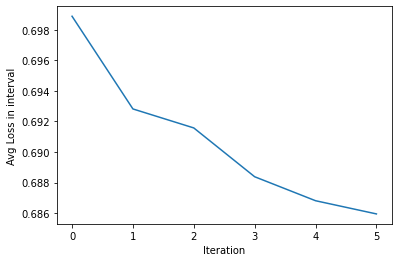

Evaluation:   0%|          | 0/1000 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:38: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


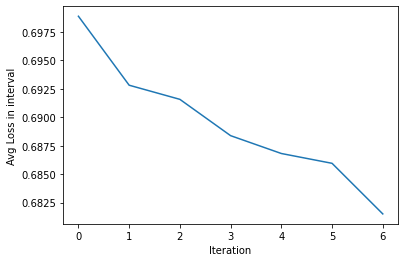

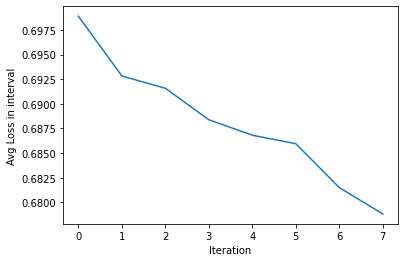

Evaluation:   0%|          | 0/1000 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:38: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


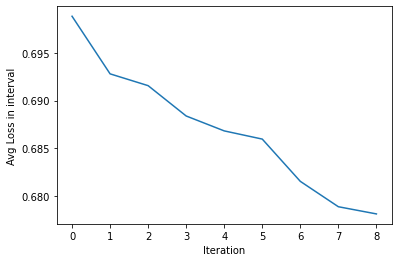

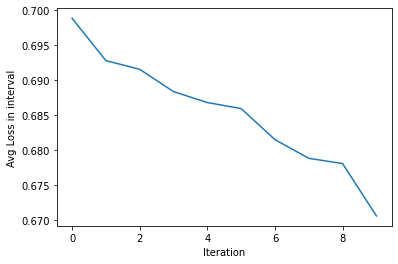

Evaluation:   0%|          | 0/1000 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:38: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


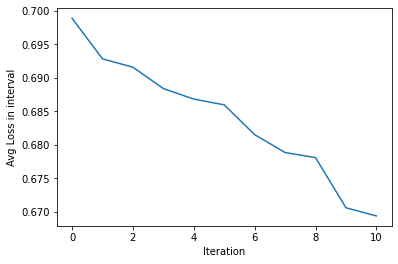

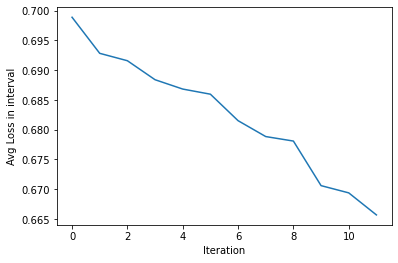

Evaluation:   0%|          | 0/1000 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:38: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


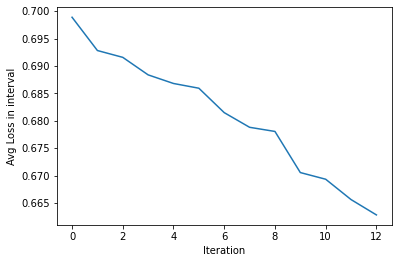

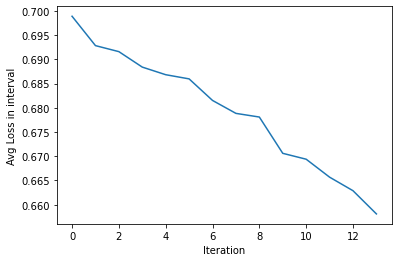

Evaluation:   0%|          | 0/1000 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:38: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


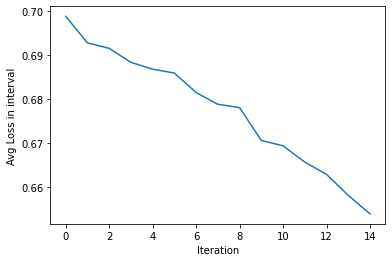

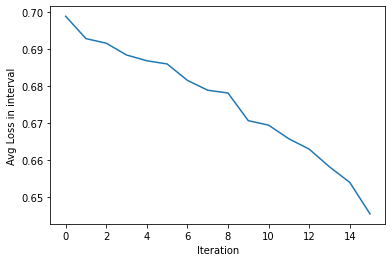

Evaluation:   0%|          | 0/1000 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:38: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


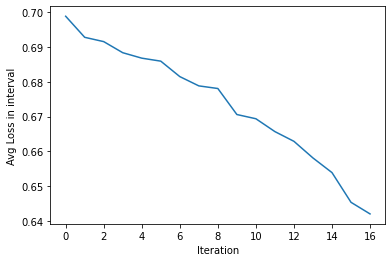

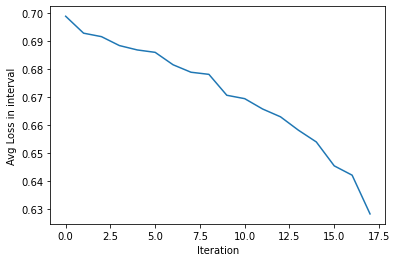

Evaluation:   0%|          | 0/1000 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:38: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


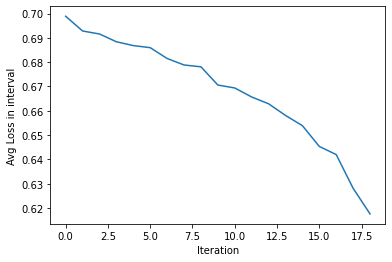

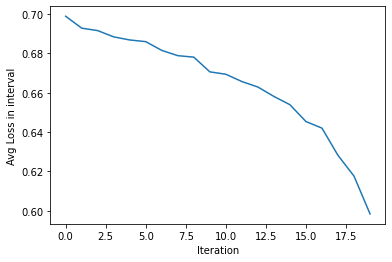

Evaluation:   0%|          | 0/1000 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:38: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


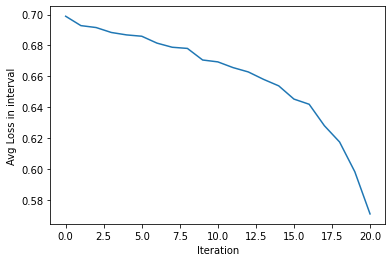

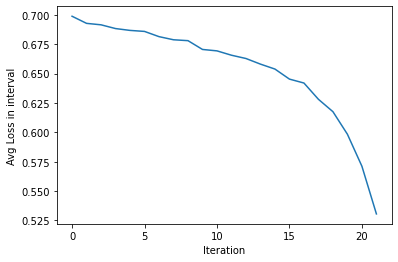

Evaluation:   0%|          | 0/1000 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:38: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


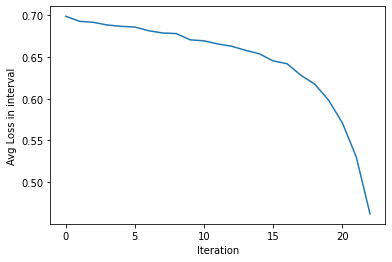

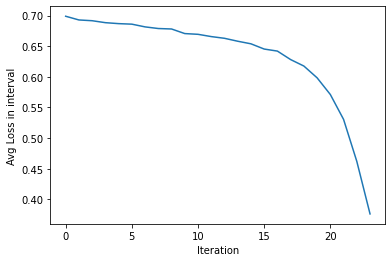

Evaluation:   0%|          | 0/1000 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:38: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


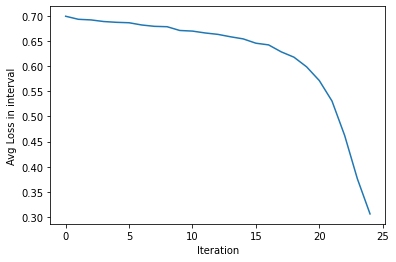

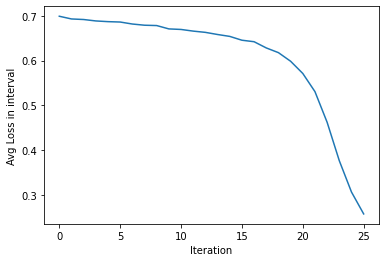

Evaluation:   0%|          | 0/1000 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:38: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


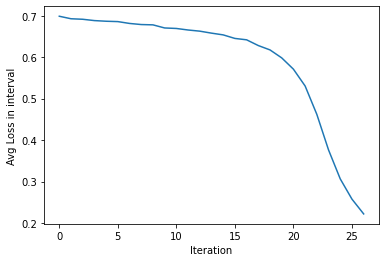

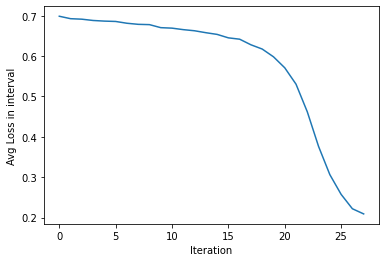

Evaluation:   0%|          | 0/1000 [00:00<?, ?it/s]

[[0.92401216 0.03725782]
 [0.01823708 0.99105812]]
              precision    recall  f1-score   support

      Faulty       0.92      0.98      0.95       310
     Healthy       0.99      0.96      0.98       690

    accuracy                           0.97      1000
   macro avg       0.96      0.97      0.96      1000
weighted avg       0.97      0.97      0.97      1000

------MODEL SAVED------
ACCURACY =  0.969


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:38: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


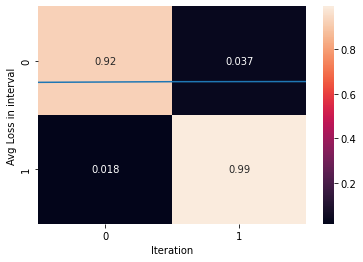

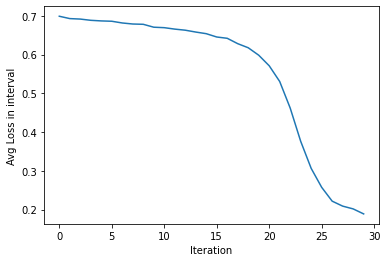

Evaluation:   0%|          | 0/1000 [00:00<?, ?it/s]

[[0.92073171 0.03869048]
 [0.00609756 0.99702381]]
              precision    recall  f1-score   support

      Faulty       0.92      0.99      0.96       304
     Healthy       1.00      0.96      0.98       696

    accuracy                           0.97      1000
   macro avg       0.96      0.98      0.97      1000
weighted avg       0.97      0.97      0.97      1000

------MODEL SAVED------
ACCURACY =  0.972


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:38: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


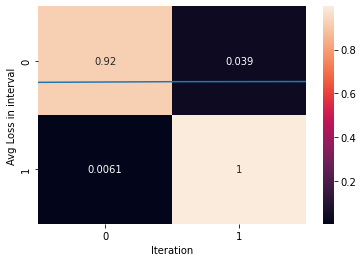

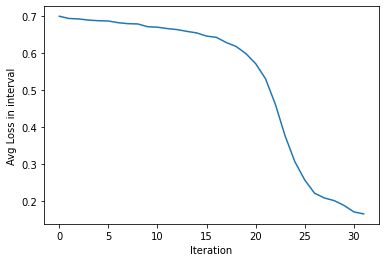

Evaluation:   0%|          | 0/1000 [00:00<?, ?it/s]

[[0.91666667 0.03994083]
 [0.00617284 0.99704142]]
              precision    recall  f1-score   support

      Faulty       0.92      0.99      0.95       299
     Healthy       1.00      0.96      0.98       701

    accuracy                           0.97      1000
   macro avg       0.96      0.98      0.97      1000
weighted avg       0.97      0.97      0.97      1000

------MODEL SAVED------


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:38: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


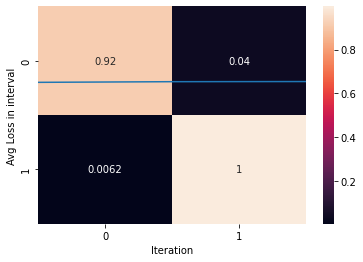

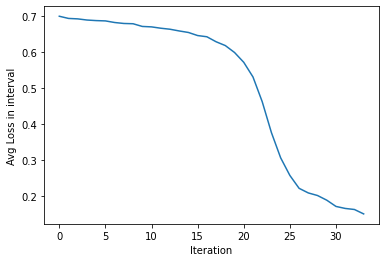

Evaluation:   0%|          | 0/1000 [00:00<?, ?it/s]

[[0.94578313 0.02694611]
 [0.01506024 0.99251497]]
              precision    recall  f1-score   support

      Faulty       0.95      0.98      0.96       319
     Healthy       0.99      0.97      0.98       681

    accuracy                           0.98      1000
   macro avg       0.97      0.98      0.97      1000
weighted avg       0.98      0.98      0.98      1000

------MODEL SAVED------
ACCURACY =  0.977


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:38: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


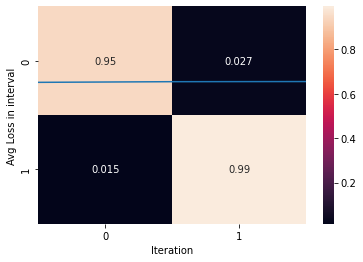

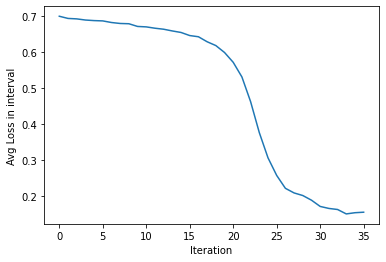

Evaluation:   0%|          | 0/1000 [00:00<?, ?it/s]

[[0.92634561 0.04018547]
 [0.         1.        ]]
              precision    recall  f1-score   support

      Faulty       0.93      1.00      0.96       327
     Healthy       1.00      0.96      0.98       673

    accuracy                           0.97      1000
   macro avg       0.96      0.98      0.97      1000
weighted avg       0.98      0.97      0.97      1000

------MODEL SAVED------


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:38: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


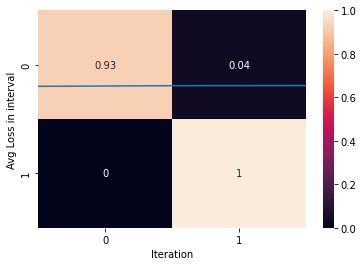

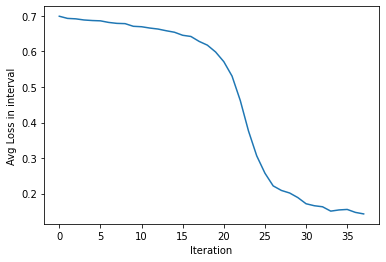

Evaluation:   0%|          | 0/1000 [00:00<?, ?it/s]

[[0.92923077 0.03407407]
 [0.         1.        ]]
              precision    recall  f1-score   support

      Faulty       0.93      1.00      0.96       302
     Healthy       1.00      0.97      0.98       698

    accuracy                           0.98      1000
   macro avg       0.96      0.98      0.97      1000
weighted avg       0.98      0.98      0.98      1000

------MODEL SAVED------


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:38: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


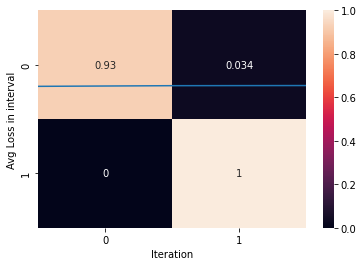

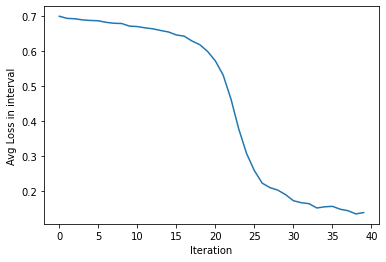

Evaluation:   0%|          | 0/1000 [00:00<?, ?it/s]

[[0.93518519 0.03106509]
 [0.00925926 0.99556213]]
              precision    recall  f1-score   support

      Faulty       0.94      0.99      0.96       306
     Healthy       1.00      0.97      0.98       694

    accuracy                           0.98      1000
   macro avg       0.97      0.98      0.97      1000
weighted avg       0.98      0.98      0.98      1000

------MODEL SAVED------


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:38: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


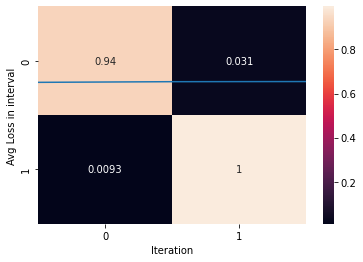

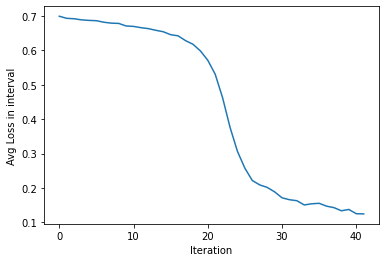

Evaluation:   0%|          | 0/1000 [00:00<?, ?it/s]

[[0.92243767 0.04381847]
 [0.00554017 0.99687011]]
              precision    recall  f1-score   support

      Faulty       0.92      0.99      0.96       335
     Healthy       1.00      0.96      0.98       665

    accuracy                           0.97      1000
   macro avg       0.96      0.98      0.97      1000
weighted avg       0.97      0.97      0.97      1000

------MODEL SAVED------


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:38: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


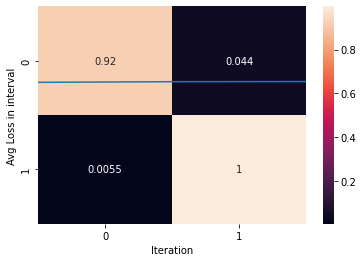

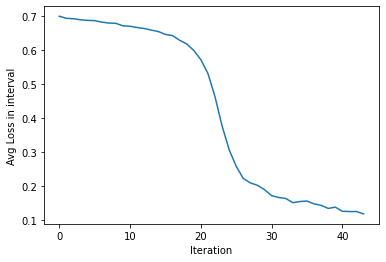

Evaluation:   0%|          | 0/1000 [00:00<?, ?it/s]

[[0.93624161 0.02706553]
 [0.01006711 0.9957265 ]]
              precision    recall  f1-score   support

      Faulty       0.94      0.99      0.96       282
     Healthy       1.00      0.97      0.98       718

    accuracy                           0.98      1000
   macro avg       0.97      0.98      0.97      1000
weighted avg       0.98      0.98      0.98      1000

------MODEL SAVED------
ACCURACY =  0.978


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:38: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


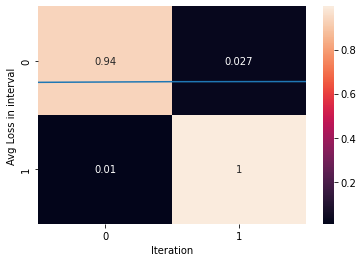

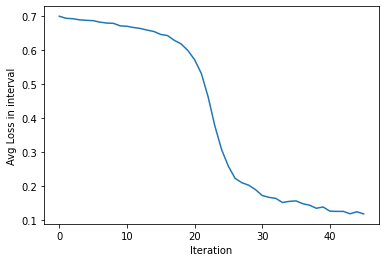

Evaluation:   0%|          | 0/1000 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:38: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


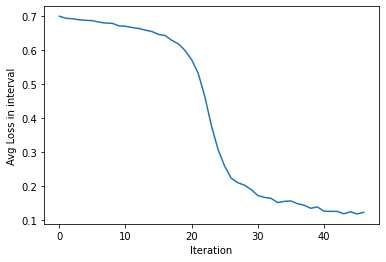

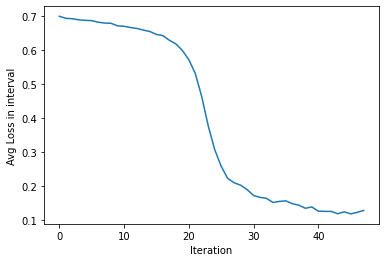

Evaluation:   0%|          | 0/1000 [00:00<?, ?it/s]

[[0.93518519 0.03106509]
 [0.00308642 0.99852071]]
              precision    recall  f1-score   support

      Faulty       0.94      1.00      0.96       304
     Healthy       1.00      0.97      0.98       696

    accuracy                           0.98      1000
   macro avg       0.97      0.98      0.97      1000
weighted avg       0.98      0.98      0.98      1000

------MODEL SAVED------


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:38: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


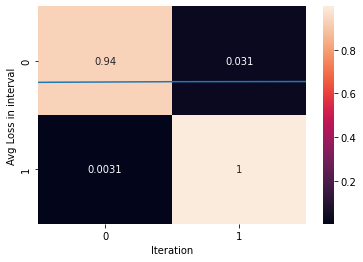

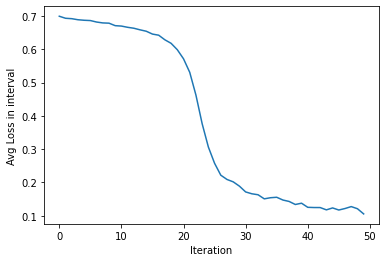

Evaluation:   0%|          | 0/1000 [00:00<?, ?it/s]

[[0.93841642 0.03186646]
 [0.         1.        ]]
              precision    recall  f1-score   support

      Faulty       0.94      1.00      0.97       320
     Healthy       1.00      0.97      0.98       680

    accuracy                           0.98      1000
   macro avg       0.97      0.98      0.98      1000
weighted avg       0.98      0.98      0.98      1000

------MODEL SAVED------
ACCURACY =  0.979


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:38: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


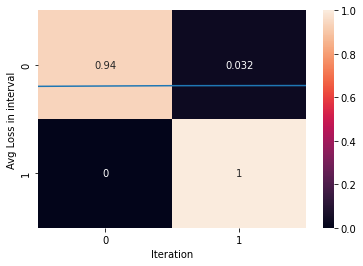

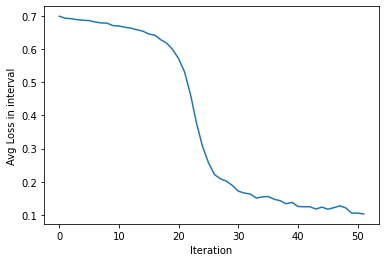

Evaluation:   0%|          | 0/1000 [00:00<?, ?it/s]

[[0.90517241 0.0506135 ]
 [0.         1.        ]]
              precision    recall  f1-score   support

      Faulty       0.91      1.00      0.95       315
     Healthy       1.00      0.95      0.98       685

    accuracy                           0.97      1000
   macro avg       0.95      0.98      0.96      1000
weighted avg       0.97      0.97      0.97      1000

------MODEL SAVED------


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:38: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


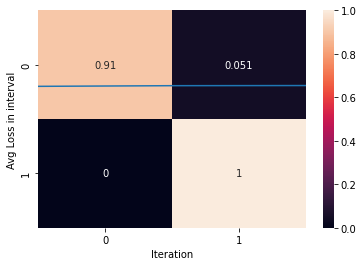

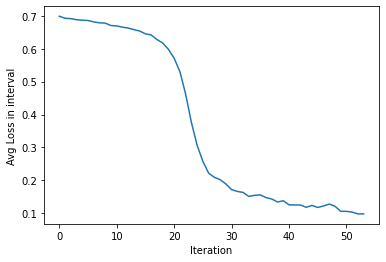

Evaluation:   0%|          | 0/1000 [00:00<?, ?it/s]

[[0.91692308 0.04      ]
 [0.00923077 0.99555556]]
              precision    recall  f1-score   support

      Faulty       0.92      0.99      0.95       301
     Healthy       1.00      0.96      0.98       699

    accuracy                           0.97      1000
   macro avg       0.96      0.98      0.97      1000
weighted avg       0.97      0.97      0.97      1000

------MODEL SAVED------


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:38: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


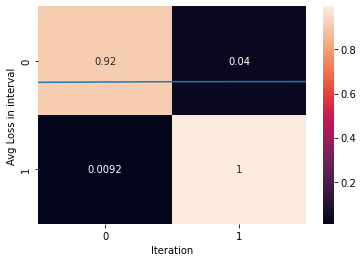

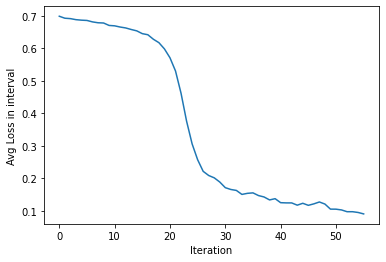

Evaluation:   0%|          | 0/1000 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:38: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


[[0.93134328 0.03458647]
 [0.         1.        ]]
              precision    recall  f1-score   support

      Faulty       0.93      1.00      0.96       312
     Healthy       1.00      0.97      0.98       688

    accuracy                           0.98      1000
   macro avg       0.97      0.98      0.97      1000
weighted avg       0.98      0.98      0.98      1000

------MODEL SAVED------


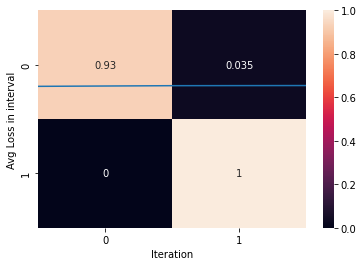

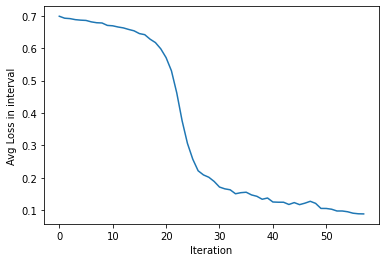

Evaluation:   0%|          | 0/1000 [00:00<?, ?it/s]

[[0.91202346 0.04552352]
 [0.         1.        ]]
              precision    recall  f1-score   support

      Faulty       0.91      1.00      0.95       311
     Healthy       1.00      0.96      0.98       689

    accuracy                           0.97      1000
   macro avg       0.96      0.98      0.97      1000
weighted avg       0.97      0.97      0.97      1000

------MODEL SAVED------


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:38: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


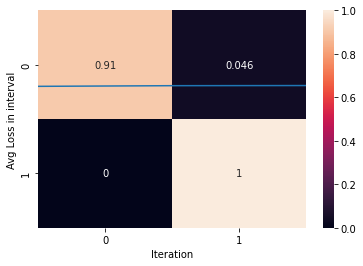

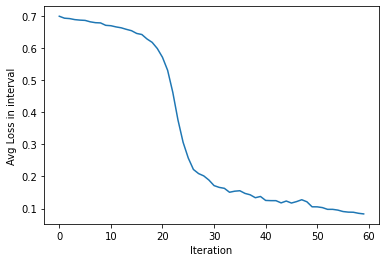

Evaluation:   0%|          | 0/1000 [00:00<?, ?it/s]

[[0.92307692 0.04160247]
 [0.002849   0.99845917]]
              precision    recall  f1-score   support

      Faulty       0.92      1.00      0.96       325
     Healthy       1.00      0.96      0.98       675

    accuracy                           0.97      1000
   macro avg       0.96      0.98      0.97      1000
weighted avg       0.97      0.97      0.97      1000

------MODEL SAVED------


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:38: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


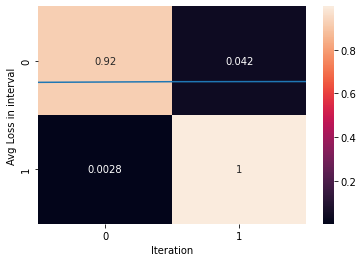

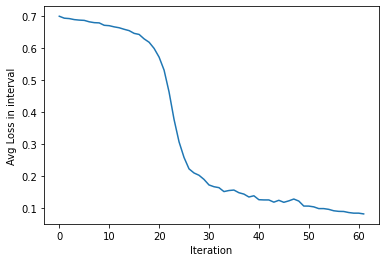

Evaluation:   0%|          | 0/1000 [00:00<?, ?it/s]

[[0.95       0.02142857]
 [0.01       0.99571429]]
              precision    recall  f1-score   support

      Faulty       0.95      0.99      0.97       288
     Healthy       1.00      0.98      0.99       712

    accuracy                           0.98      1000
   macro avg       0.97      0.98      0.98      1000
weighted avg       0.98      0.98      0.98      1000

------MODEL SAVED------
ACCURACY =  0.982


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:38: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


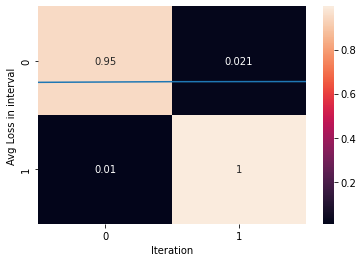

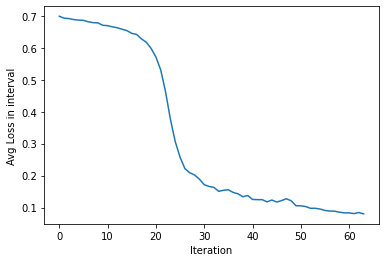

Evaluation:   0%|          | 0/1000 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:38: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


[[0.93831169 0.02745665]
 [0.00649351 0.99710983]]
              precision    recall  f1-score   support

      Faulty       0.94      0.99      0.96       291
     Healthy       1.00      0.97      0.99       709

    accuracy                           0.98      1000
   macro avg       0.97      0.98      0.97      1000
weighted avg       0.98      0.98      0.98      1000

------MODEL SAVED------


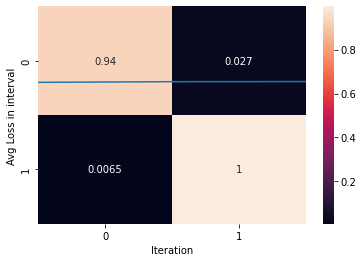

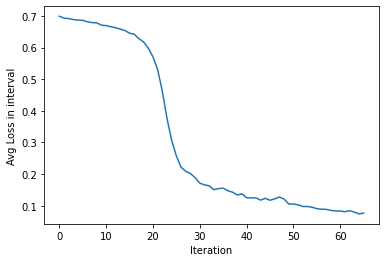

Evaluation:   0%|          | 0/1000 [00:00<?, ?it/s]

[[0.95098039 0.02161383]
 [0.00980392 0.99567723]]
              precision    recall  f1-score   support

      Faulty       0.95      0.99      0.97       294
     Healthy       1.00      0.98      0.99       706

    accuracy                           0.98      1000
   macro avg       0.97      0.98      0.98      1000
weighted avg       0.98      0.98      0.98      1000

------MODEL SAVED------


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:38: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


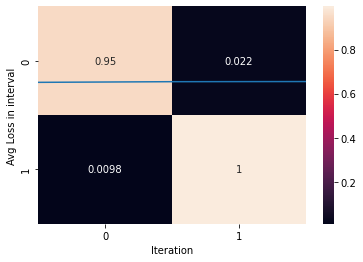

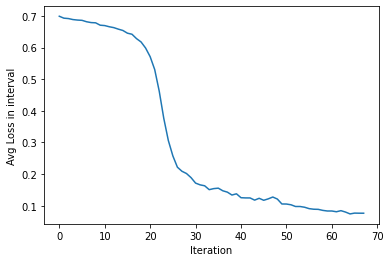

Evaluation:   0%|          | 0/1000 [00:00<?, ?it/s]

[[0.95454545 0.02238806]
 [0.00909091 0.99552239]]
              precision    recall  f1-score   support

      Faulty       0.95      0.99      0.97       318
     Healthy       1.00      0.98      0.99       682

    accuracy                           0.98      1000
   macro avg       0.98      0.98      0.98      1000
weighted avg       0.98      0.98      0.98      1000

------MODEL SAVED------


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:38: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


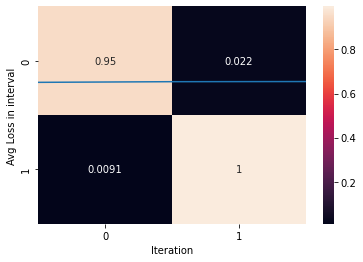

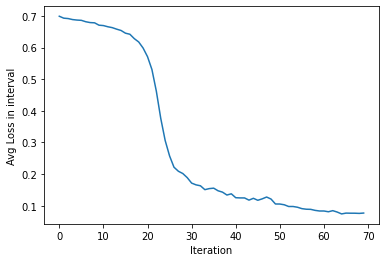

Evaluation:   0%|          | 0/1000 [00:00<?, ?it/s]

[[0.95335277 0.02435312]
 [0.00874636 0.99543379]]
              precision    recall  f1-score   support

      Faulty       0.95      0.99      0.97       330
     Healthy       1.00      0.98      0.99       670

    accuracy                           0.98      1000
   macro avg       0.97      0.98      0.98      1000
weighted avg       0.98      0.98      0.98      1000

------MODEL SAVED------


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:38: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


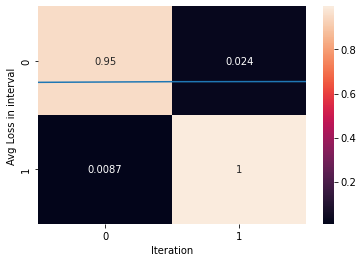

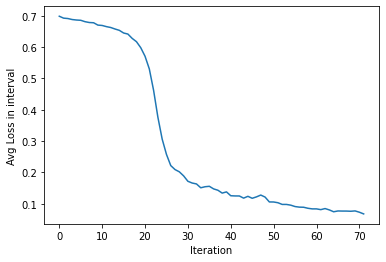

Evaluation:   0%|          | 0/1000 [00:00<?, ?it/s]

[[0.95481928 0.02245509]
 [0.00301205 0.99850299]]
              precision    recall  f1-score   support

      Faulty       0.95      1.00      0.98       318
     Healthy       1.00      0.98      0.99       682

    accuracy                           0.98      1000
   macro avg       0.98      0.99      0.98      1000
weighted avg       0.98      0.98      0.98      1000

------MODEL SAVED------
ACCURACY =  0.984


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:38: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


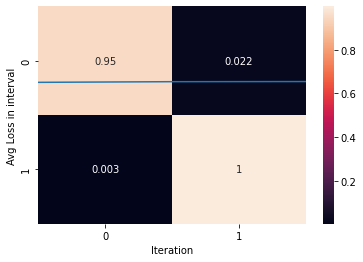

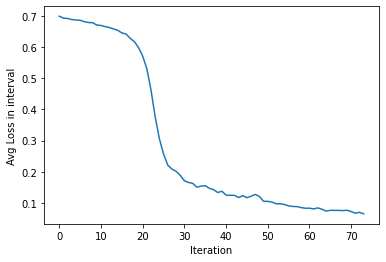

Evaluation:   0%|          | 0/1000 [00:00<?, ?it/s]

[[0.940625   0.02794118]
 [0.003125   0.99852941]]
              precision    recall  f1-score   support

      Faulty       0.94      1.00      0.97       302
     Healthy       1.00      0.97      0.99       698

    accuracy                           0.98      1000
   macro avg       0.97      0.98      0.98      1000
weighted avg       0.98      0.98      0.98      1000

------MODEL SAVED------


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:38: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


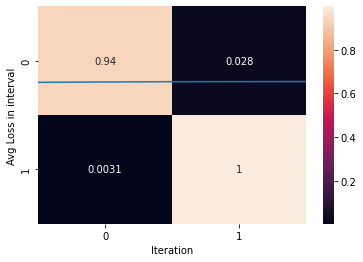

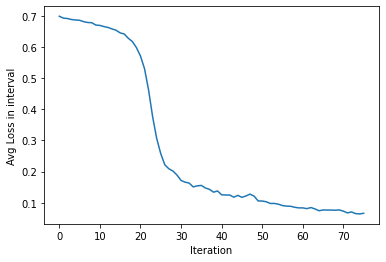

Evaluation:   0%|          | 0/1000 [00:00<?, ?it/s]

[[0.95924765 0.01908957]
 [0.         1.        ]]
              precision    recall  f1-score   support

      Faulty       0.96      1.00      0.98       306
     Healthy       1.00      0.98      0.99       694

    accuracy                           0.99      1000
   macro avg       0.98      0.99      0.98      1000
weighted avg       0.99      0.99      0.99      1000

------MODEL SAVED------
ACCURACY =  0.987


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:38: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


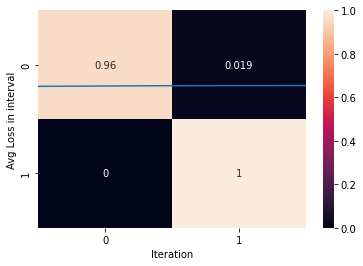

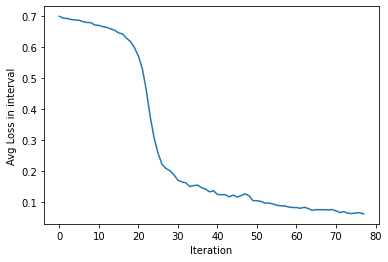

Evaluation:   0%|          | 0/1000 [00:00<?, ?it/s]

[[0.934375   0.03088235]
 [0.         1.        ]]
              precision    recall  f1-score   support

      Faulty       0.93      1.00      0.97       299
     Healthy       1.00      0.97      0.98       701

    accuracy                           0.98      1000
   macro avg       0.97      0.99      0.98      1000
weighted avg       0.98      0.98      0.98      1000

------MODEL SAVED------


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:38: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


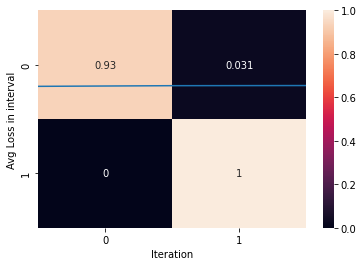

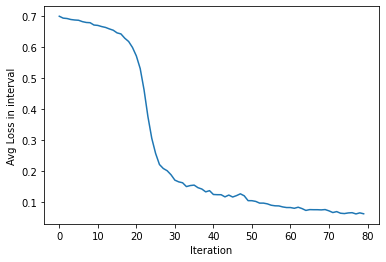

Evaluation:   0%|          | 0/1000 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:38: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


[[0.95738636 0.02314815]
 [0.00284091 0.99845679]]
              precision    recall  f1-score   support

      Faulty       0.96      1.00      0.98       338
     Healthy       1.00      0.98      0.99       662

    accuracy                           0.98      1000
   macro avg       0.98      0.99      0.98      1000
weighted avg       0.98      0.98      0.98      1000

------MODEL SAVED------


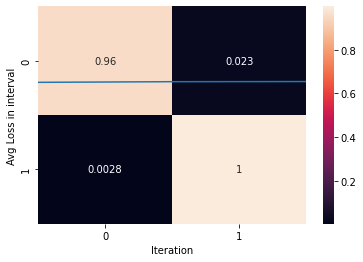

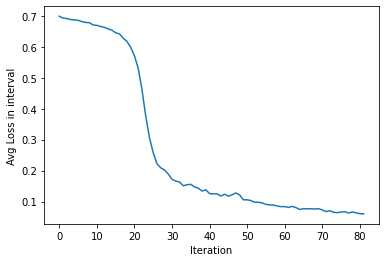

Evaluation:   0%|          | 0/1000 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:38: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


[[0.91304348 0.04129794]
 [0.         1.        ]]
              precision    recall  f1-score   support

      Faulty       0.91      1.00      0.95       294
     Healthy       1.00      0.96      0.98       706

    accuracy                           0.97      1000
   macro avg       0.96      0.98      0.97      1000
weighted avg       0.97      0.97      0.97      1000

------MODEL SAVED------


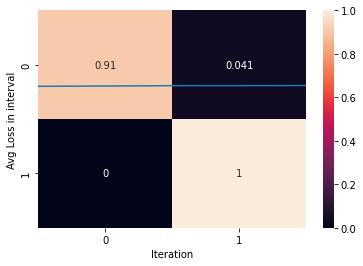

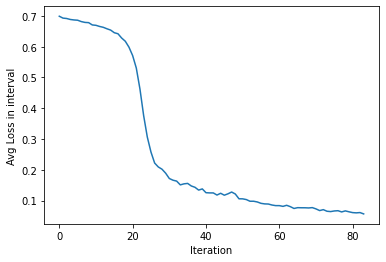

Evaluation:   0%|          | 0/1000 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:38: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


[[0.96480938 0.01820941]
 [0.         1.        ]]
              precision    recall  f1-score   support

      Faulty       0.96      1.00      0.98       329
     Healthy       1.00      0.98      0.99       671

    accuracy                           0.99      1000
   macro avg       0.98      0.99      0.99      1000
weighted avg       0.99      0.99      0.99      1000

------MODEL SAVED------
ACCURACY =  0.988


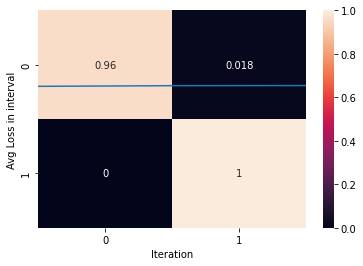

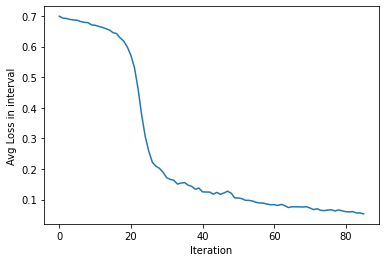

Evaluation:   0%|          | 0/1000 [00:00<?, ?it/s]

[[0.94986072 0.02808112]
 [0.         1.        ]]
              precision    recall  f1-score   support

      Faulty       0.95      1.00      0.97       341
     Healthy       1.00      0.97      0.99       659

    accuracy                           0.98      1000
   macro avg       0.97      0.99      0.98      1000
weighted avg       0.98      0.98      0.98      1000

------MODEL SAVED------


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:38: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


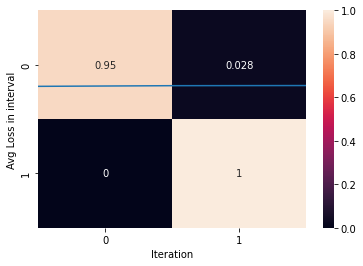

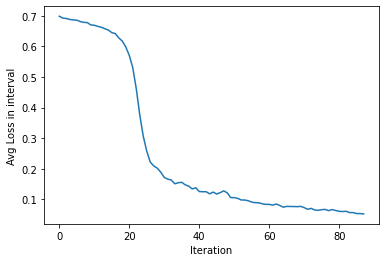

Evaluation:   0%|          | 0/1000 [00:00<?, ?it/s]

[[0.96130952 0.01957831]
 [0.         1.        ]]
              precision    recall  f1-score   support

      Faulty       0.96      1.00      0.98       323
     Healthy       1.00      0.98      0.99       677

    accuracy                           0.99      1000
   macro avg       0.98      0.99      0.99      1000
weighted avg       0.99      0.99      0.99      1000

------MODEL SAVED------


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:38: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


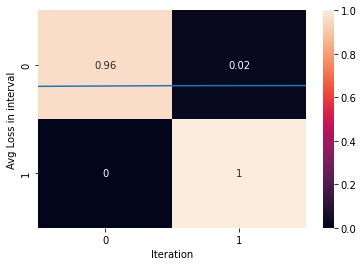

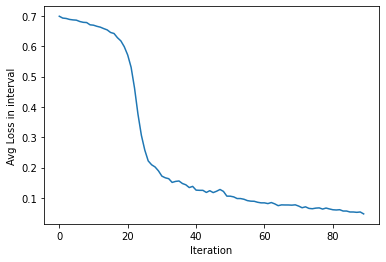

Evaluation:   0%|          | 0/1000 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:38: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


[[0.95988539 0.02150538]
 [0.00286533 0.9984639 ]]
              precision    recall  f1-score   support

      Faulty       0.96      1.00      0.98       336
     Healthy       1.00      0.98      0.99       664

    accuracy                           0.98      1000
   macro avg       0.98      0.99      0.98      1000
weighted avg       0.99      0.98      0.99      1000

------MODEL SAVED------


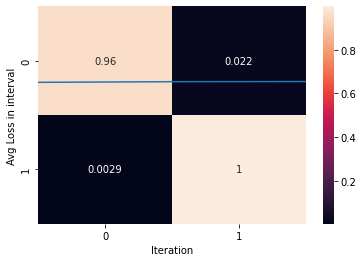

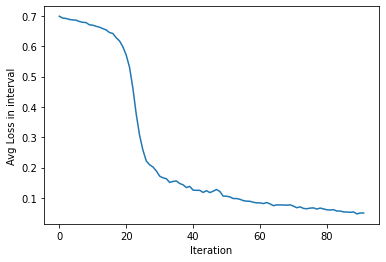

Evaluation:   0%|          | 0/1000 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:38: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


[[0.95356037 0.02215657]
 [0.         1.        ]]
              precision    recall  f1-score   support

      Faulty       0.95      1.00      0.98       308
     Healthy       1.00      0.98      0.99       692

    accuracy                           0.98      1000
   macro avg       0.98      0.99      0.98      1000
weighted avg       0.99      0.98      0.99      1000

------MODEL SAVED------


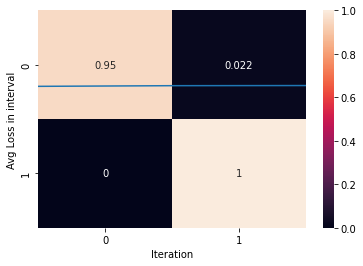

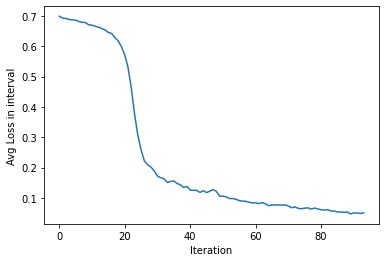

Evaluation:   0%|          | 0/1000 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:38: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


[[0.93567251 0.03343465]
 [0.         1.        ]]
              precision    recall  f1-score   support

      Faulty       0.94      1.00      0.97       320
     Healthy       1.00      0.97      0.98       680

    accuracy                           0.98      1000
   macro avg       0.97      0.98      0.98      1000
weighted avg       0.98      0.98      0.98      1000

------MODEL SAVED------


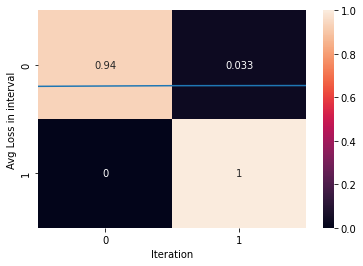

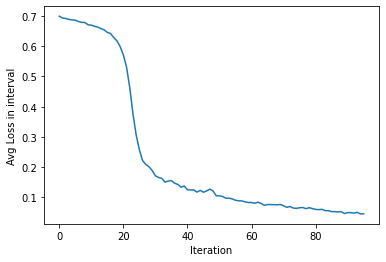

Evaluation:   0%|          | 0/1000 [00:00<?, ?it/s]

[[0.95857988 0.02114804]
 [0.         1.        ]]
              precision    recall  f1-score   support

      Faulty       0.96      1.00      0.98       324
     Healthy       1.00      0.98      0.99       676

    accuracy                           0.99      1000
   macro avg       0.98      0.99      0.98      1000
weighted avg       0.99      0.99      0.99      1000

------MODEL SAVED------


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:38: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


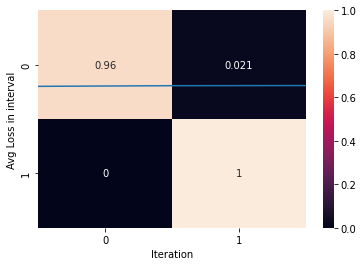

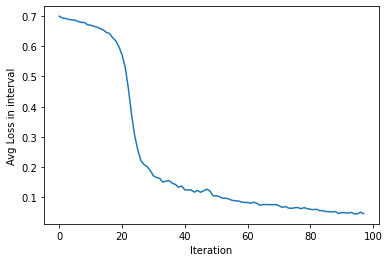

Evaluation:   0%|          | 0/1000 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:38: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


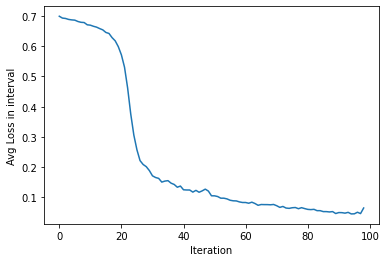

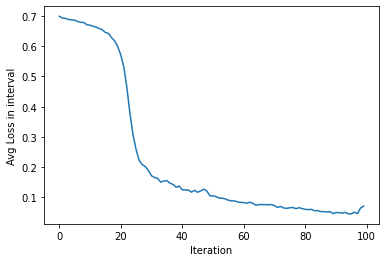

Evaluation:   0%|          | 0/1000 [00:00<?, ?it/s]

[[0.92961877 0.03641882]
 [0.         1.        ]]
              precision    recall  f1-score   support

      Faulty       0.93      1.00      0.96       317
     Healthy       1.00      0.96      0.98       683

    accuracy                           0.98      1000
   macro avg       0.96      0.98      0.97      1000
weighted avg       0.98      0.98      0.98      1000

------MODEL SAVED------


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:38: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


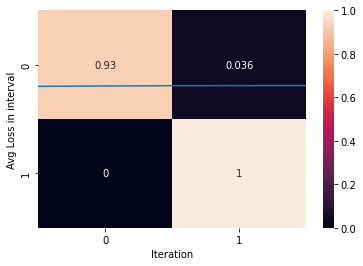

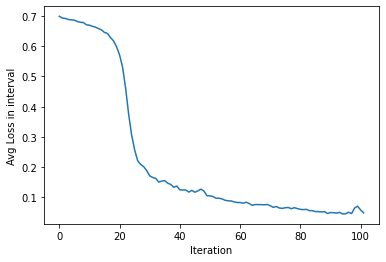

Evaluation:   0%|          | 0/1000 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:38: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


[[0.95625    0.02058824]
 [0.         1.        ]]
              precision    recall  f1-score   support

      Faulty       0.96      1.00      0.98       306
     Healthy       1.00      0.98      0.99       694

    accuracy                           0.99      1000
   macro avg       0.98      0.99      0.98      1000
weighted avg       0.99      0.99      0.99      1000

------MODEL SAVED------


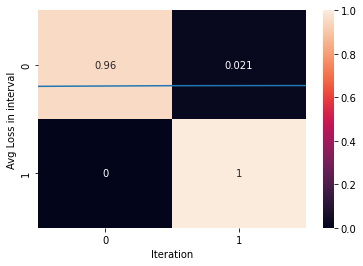

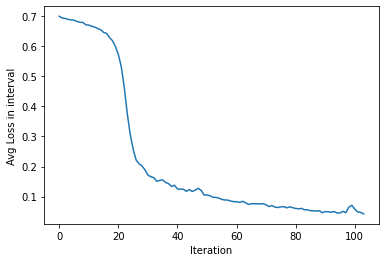

Evaluation:   0%|          | 0/1000 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:38: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


[[0.96541787 0.01837672]
 [0.00288184 0.99846861]]
              precision    recall  f1-score   support

      Faulty       0.97      1.00      0.98       336
     Healthy       1.00      0.98      0.99       664

    accuracy                           0.99      1000
   macro avg       0.98      0.99      0.99      1000
weighted avg       0.99      0.99      0.99      1000

------MODEL SAVED------


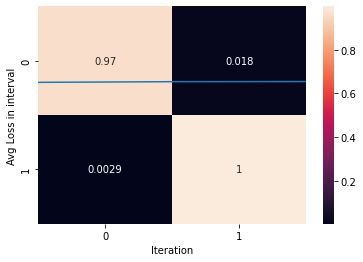

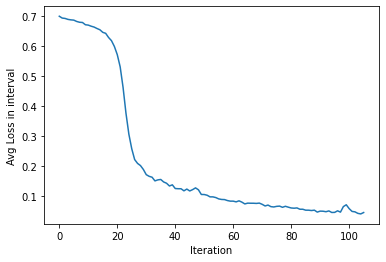

Evaluation:   0%|          | 0/1000 [00:00<?, ?it/s]

[[0.9516129  0.02866242]
 [0.00268817 0.99840764]]
              precision    recall  f1-score   support

      Faulty       0.95      1.00      0.97       355
     Healthy       1.00      0.97      0.99       645

    accuracy                           0.98      1000
   macro avg       0.98      0.98      0.98      1000
weighted avg       0.98      0.98      0.98      1000

------MODEL SAVED------


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:38: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


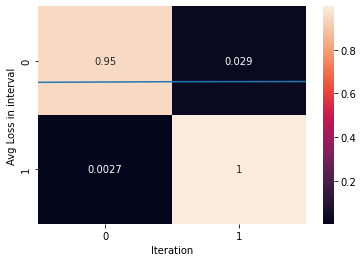

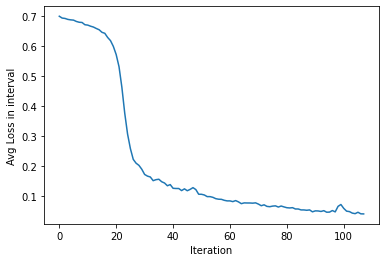

Evaluation:   0%|          | 0/1000 [00:00<?, ?it/s]

[[0.93870968 0.02753623]
 [0.         1.        ]]
              precision    recall  f1-score   support

      Faulty       0.94      1.00      0.97       291
     Healthy       1.00      0.97      0.99       709

    accuracy                           0.98      1000
   macro avg       0.97      0.99      0.98      1000
weighted avg       0.98      0.98      0.98      1000

------MODEL SAVED------


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:38: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


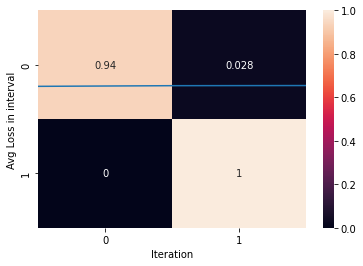

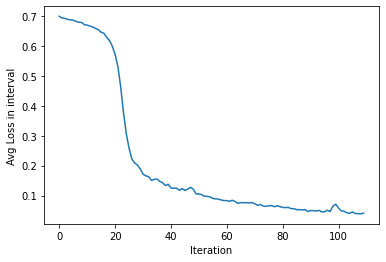

Evaluation:   0%|          | 0/1000 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:38: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


[[0.95184136 0.02627512]
 [0.00283286 0.9984544 ]]
              precision    recall  f1-score   support

      Faulty       0.95      1.00      0.97       337
     Healthy       1.00      0.97      0.99       663

    accuracy                           0.98      1000
   macro avg       0.98      0.99      0.98      1000
weighted avg       0.98      0.98      0.98      1000

------MODEL SAVED------


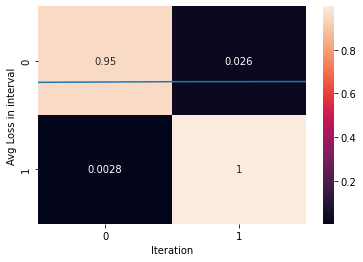

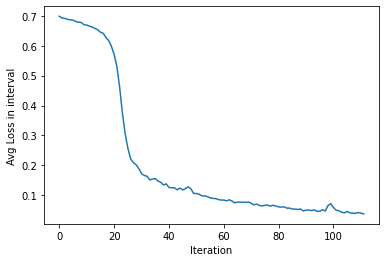

Evaluation:   0%|          | 0/1000 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:38: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


[[0.94545455 0.02686567]
 [0.         1.        ]]
              precision    recall  f1-score   support

      Faulty       0.95      1.00      0.97       312
     Healthy       1.00      0.97      0.99       688

    accuracy                           0.98      1000
   macro avg       0.97      0.99      0.98      1000
weighted avg       0.98      0.98      0.98      1000

------MODEL SAVED------


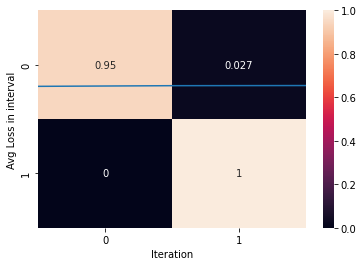

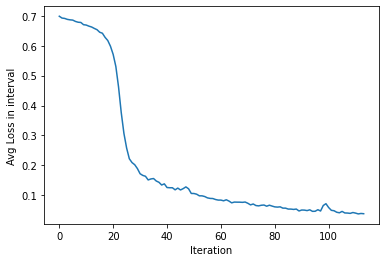

Evaluation:   0%|          | 0/1000 [00:00<?, ?it/s]

[[0.92668622 0.03793627]
 [0.         1.        ]]
              precision    recall  f1-score   support

      Faulty       0.93      1.00      0.96       316
     Healthy       1.00      0.96      0.98       684

    accuracy                           0.97      1000
   macro avg       0.96      0.98      0.97      1000
weighted avg       0.98      0.97      0.98      1000

------MODEL SAVED------


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:38: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


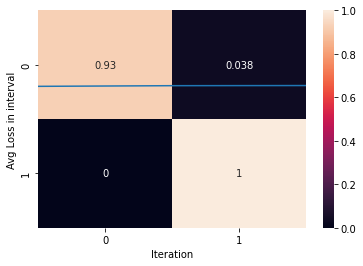

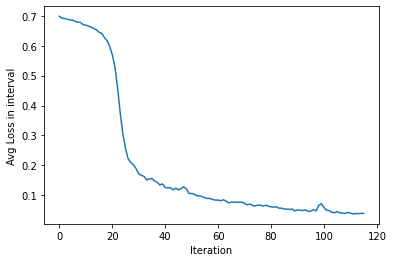

Evaluation:   0%|          | 0/1000 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:38: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


[[0.96428571 0.01807229]
 [0.00595238 0.99698795]]
              precision    recall  f1-score   support

      Faulty       0.96      0.99      0.98       326
     Healthy       1.00      0.98      0.99       674

    accuracy                           0.99      1000
   macro avg       0.98      0.99      0.98      1000
weighted avg       0.99      0.99      0.99      1000

------MODEL SAVED------


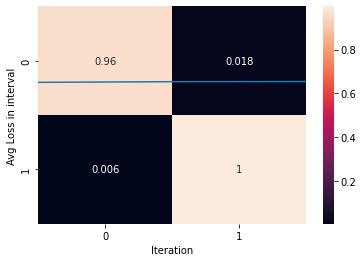

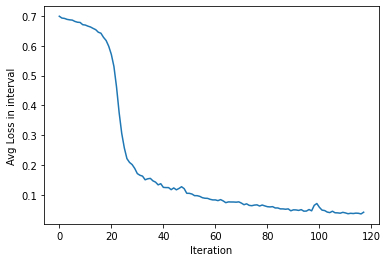

Evaluation:   0%|          | 0/1000 [00:00<?, ?it/s]

[[0.96875    0.01470588]
 [0.00625    0.99705882]]
              precision    recall  f1-score   support

      Faulty       0.97      0.99      0.98       312
     Healthy       1.00      0.99      0.99       688

    accuracy                           0.99      1000
   macro avg       0.98      0.99      0.99      1000
weighted avg       0.99      0.99      0.99      1000

------MODEL SAVED------


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:38: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


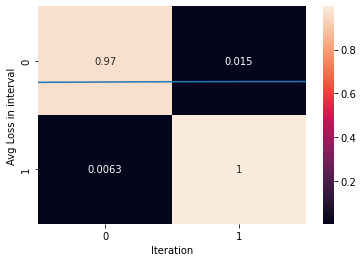

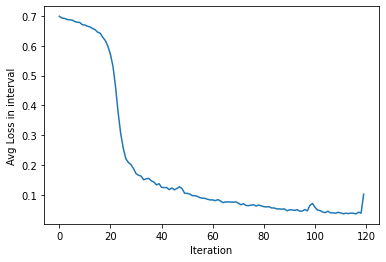

Evaluation:   0%|          | 0/1000 [00:00<?, ?it/s]

[[0.95677233 0.0229709 ]
 [0.01152738 0.99387443]]
              precision    recall  f1-score   support

      Faulty       0.96      0.99      0.97       336
     Healthy       0.99      0.98      0.99       664

    accuracy                           0.98      1000
   macro avg       0.98      0.98      0.98      1000
weighted avg       0.98      0.98      0.98      1000

------MODEL SAVED------


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:38: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


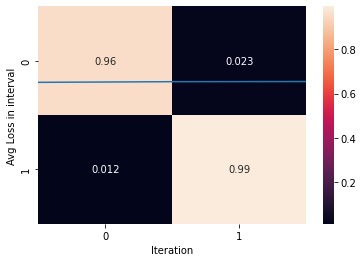

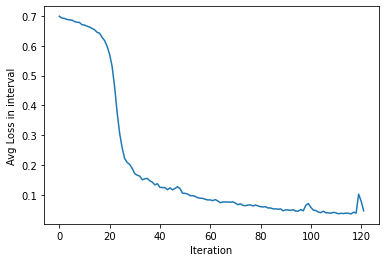

Evaluation:   0%|          | 0/1000 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:38: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


[[0.95522388 0.02255639]
 [0.01492537 0.9924812 ]]
              precision    recall  f1-score   support

      Faulty       0.96      0.98      0.97       325
     Healthy       0.99      0.98      0.99       675

    accuracy                           0.98      1000
   macro avg       0.97      0.98      0.98      1000
weighted avg       0.98      0.98      0.98      1000

------MODEL SAVED------


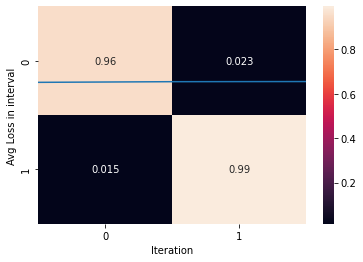

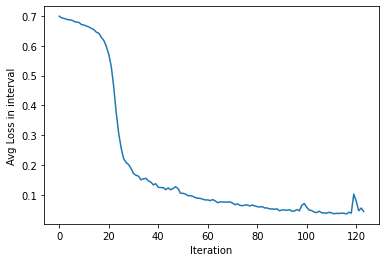

Evaluation:   0%|          | 0/1000 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:38: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


[[0.96712329 0.01889764]
 [0.00273973 0.9984252 ]]
              precision    recall  f1-score   support

      Faulty       0.97      1.00      0.98       354
     Healthy       1.00      0.98      0.99       646

    accuracy                           0.99      1000
   macro avg       0.98      0.99      0.99      1000
weighted avg       0.99      0.99      0.99      1000

------MODEL SAVED------


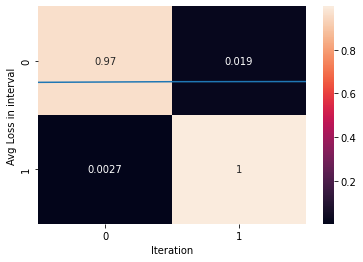

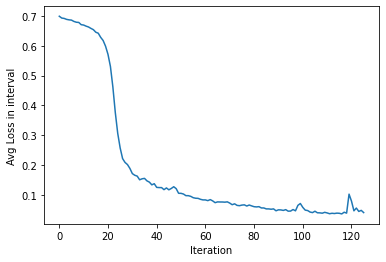

Evaluation:   0%|          | 0/1000 [00:00<?, ?it/s]

[[0.95679012 0.02071006]
 [0.         1.        ]]
              precision    recall  f1-score   support

      Faulty       0.96      1.00      0.98       310
     Healthy       1.00      0.98      0.99       690

    accuracy                           0.99      1000
   macro avg       0.98      0.99      0.98      1000
weighted avg       0.99      0.99      0.99      1000

------MODEL SAVED------


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:38: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


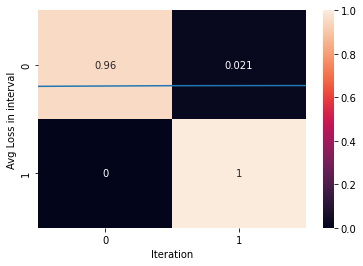

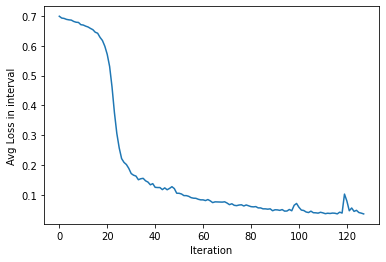

Evaluation:   0%|          | 0/1000 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:38: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


[[0.96518987 0.01608187]
 [0.         1.        ]]
              precision    recall  f1-score   support

      Faulty       0.97      1.00      0.98       305
     Healthy       1.00      0.98      0.99       695

    accuracy                           0.99      1000
   macro avg       0.98      0.99      0.99      1000
weighted avg       0.99      0.99      0.99      1000

------MODEL SAVED------
ACCURACY =  0.989


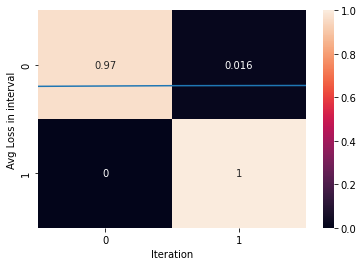

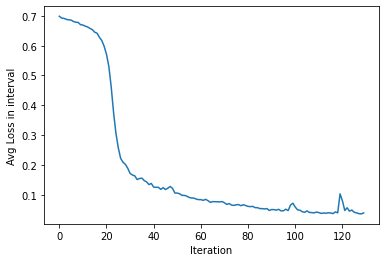

Evaluation:   0%|          | 0/1000 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:38: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


[[0.96521739 0.01832061]
 [0.00289855 0.99847328]]
              precision    recall  f1-score   support

      Faulty       0.97      1.00      0.98       334
     Healthy       1.00      0.98      0.99       666

    accuracy                           0.99      1000
   macro avg       0.98      0.99      0.99      1000
weighted avg       0.99      0.99      0.99      1000

------MODEL SAVED------


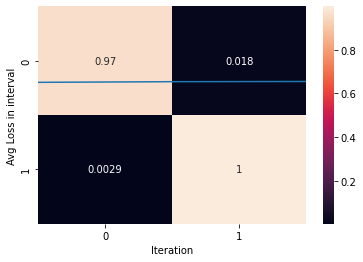

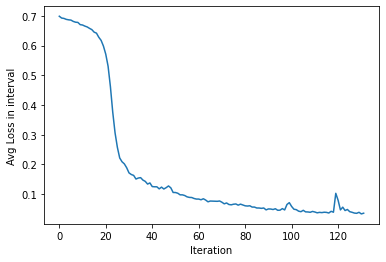

Evaluation:   0%|          | 0/1000 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:38: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


[[0.9695122  0.01488095]
 [0.         1.        ]]
              precision    recall  f1-score   support

      Faulty       0.97      1.00      0.98       318
     Healthy       1.00      0.99      0.99       682

    accuracy                           0.99      1000
   macro avg       0.98      0.99      0.99      1000
weighted avg       0.99      0.99      0.99      1000

------MODEL SAVED------
ACCURACY =  0.99


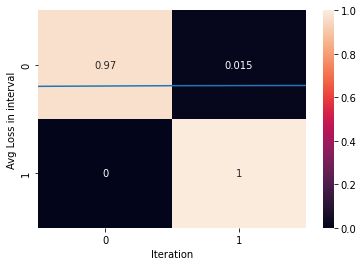

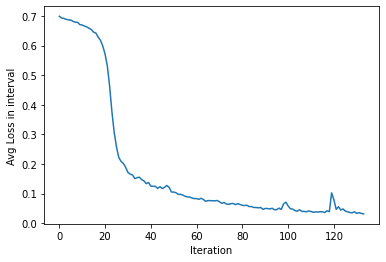

Evaluation:   0%|          | 0/1000 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:38: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


[[0.94620253 0.0248538 ]
 [0.00316456 0.99853801]]
              precision    recall  f1-score   support

      Faulty       0.95      1.00      0.97       300
     Healthy       1.00      0.98      0.99       700

    accuracy                           0.98      1000
   macro avg       0.97      0.99      0.98      1000
weighted avg       0.98      0.98      0.98      1000

------MODEL SAVED------


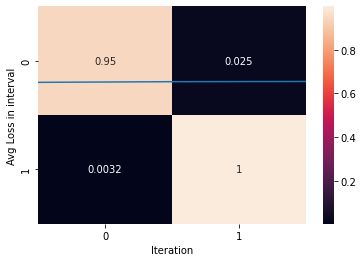

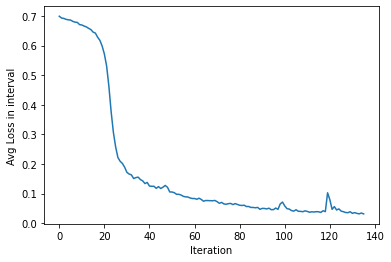

Evaluation:   0%|          | 0/1000 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:38: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


[[0.93617021 0.03129657]
 [0.         1.        ]]
              precision    recall  f1-score   support

      Faulty       0.94      1.00      0.97       308
     Healthy       1.00      0.97      0.98       692

    accuracy                           0.98      1000
   macro avg       0.97      0.98      0.98      1000
weighted avg       0.98      0.98      0.98      1000

------MODEL SAVED------


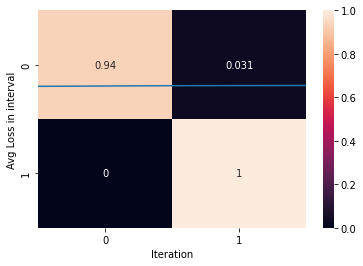

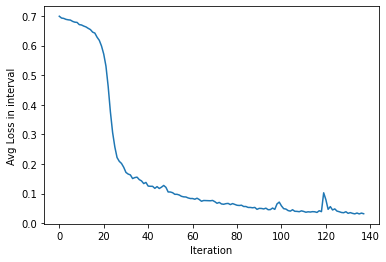

Evaluation:   0%|          | 0/1000 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:38: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


[[0.95665635 0.02067947]
 [0.         1.        ]]
              precision    recall  f1-score   support

      Faulty       0.96      1.00      0.98       309
     Healthy       1.00      0.98      0.99       691

    accuracy                           0.99      1000
   macro avg       0.98      0.99      0.98      1000
weighted avg       0.99      0.99      0.99      1000

------MODEL SAVED------


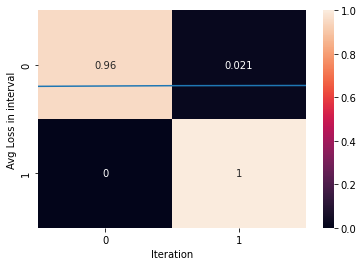

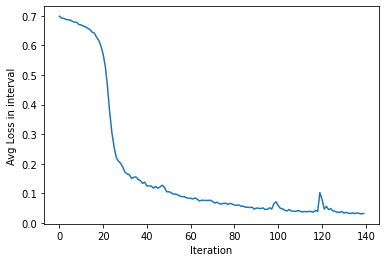

Evaluation:   0%|          | 0/1000 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:38: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


[[0.95426829 0.02232143]
 [0.         1.        ]]
              precision    recall  f1-score   support

      Faulty       0.95      1.00      0.98       313
     Healthy       1.00      0.98      0.99       687

    accuracy                           0.98      1000
   macro avg       0.98      0.99      0.98      1000
weighted avg       0.99      0.98      0.99      1000

------MODEL SAVED------


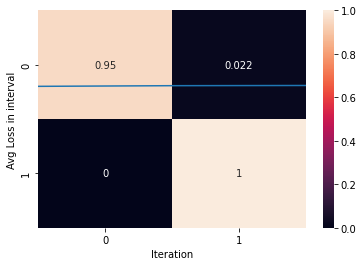

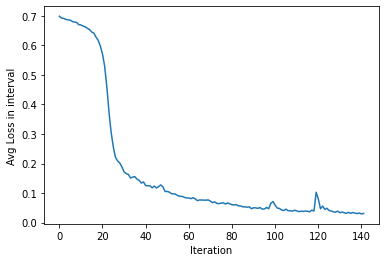

Evaluation:   0%|          | 0/1000 [00:00<?, ?it/s]

[[0.96573209 0.01620029]
 [0.         1.        ]]
              precision    recall  f1-score   support

      Faulty       0.97      1.00      0.98       310
     Healthy       1.00      0.98      0.99       690

    accuracy                           0.99      1000
   macro avg       0.98      0.99      0.99      1000
weighted avg       0.99      0.99      0.99      1000

------MODEL SAVED------


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:38: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


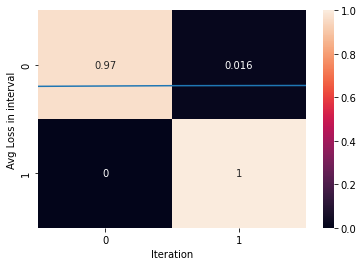

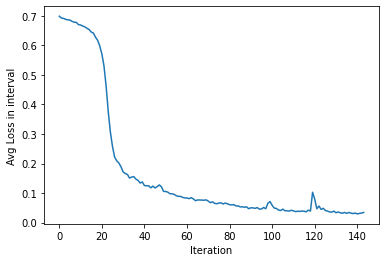

Evaluation:   0%|          | 0/1000 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:38: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


[[0.93837535 0.03421462]
 [0.         1.        ]]
              precision    recall  f1-score   support

      Faulty       0.94      1.00      0.97       335
     Healthy       1.00      0.97      0.98       665

    accuracy                           0.98      1000
   macro avg       0.97      0.98      0.98      1000
weighted avg       0.98      0.98      0.98      1000

------MODEL SAVED------


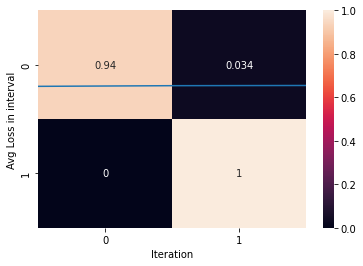

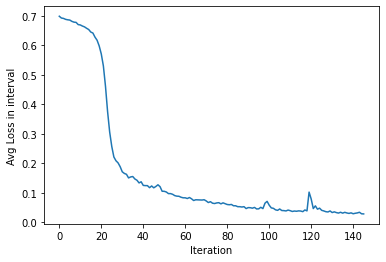

Evaluation:   0%|          | 0/1000 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:38: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


[[0.9752322  0.01181684]
 [0.00309598 0.9985229 ]]
              precision    recall  f1-score   support

      Faulty       0.98      1.00      0.99       316
     Healthy       1.00      0.99      0.99       684

    accuracy                           0.99      1000
   macro avg       0.99      0.99      0.99      1000
weighted avg       0.99      0.99      0.99      1000

------MODEL SAVED------
ACCURACY =  0.991


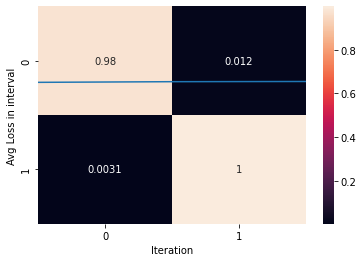

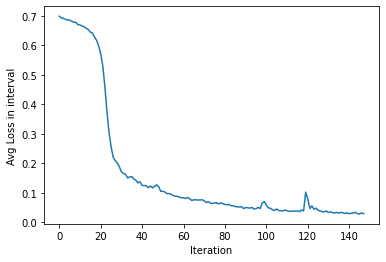

Evaluation:   0%|          | 0/1000 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:38: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


[[0.96060606 0.01940299]
 [0.0030303  0.99850746]]
              precision    recall  f1-score   support

      Faulty       0.96      1.00      0.98       318
     Healthy       1.00      0.98      0.99       682

    accuracy                           0.99      1000
   macro avg       0.98      0.99      0.98      1000
weighted avg       0.99      0.99      0.99      1000

------MODEL SAVED------


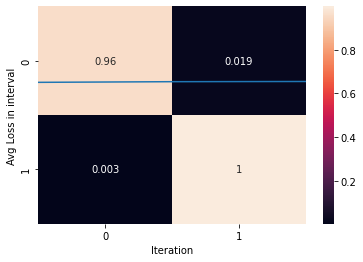

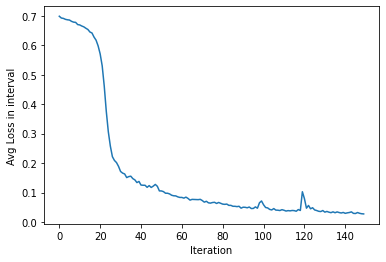

In [50]:
opt=optim.Adam(model.parameters(),lr=0.0001)
device_gpu=torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
loss_arr,loss_plot,acc_plot,most_accurate_model,req_model=train_setup(model,opt,data,train_starting_points,priv_data,n_batches,batch_size=512,display_frequency=20,device=device_gpu)

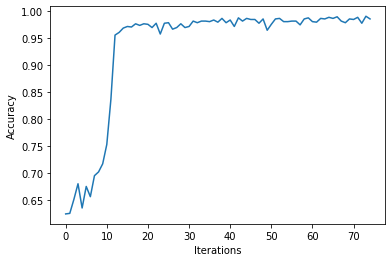

In [54]:
plt.plot(acc_plot)
plt.xlabel('Iterations')
plt.ylabel('Accuracy')
plt.show()

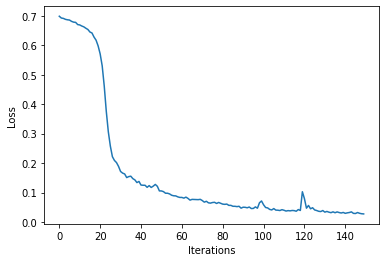

In [55]:
plt.plot(loss_plot)
plt.xlabel('Iterations')
plt.ylabel('Loss value')
plt.show()

##Private Data Evaluation

In [102]:
#Hyperparameter assignments
sample_size=1000
batch_size=128
input_size=4
hidden_size=32
output_size=1
num_layers=1
n_batches=250
best_model=LSTM_net(input_size=input_size,hidden_size=hidden_size,output_size=output_size,num_layers=num_layers)
best_model.load_state_dict(most_accurate_model)

<All keys matched successfully>

Evaluation:   0%|          | 0/38000 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:41: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


[[0.93665726 0.03200761]
 [0.01795234 0.99092854]]
              precision    recall  f1-score   support

      Faulty       0.94      0.98      0.96     12177
     Healthy       0.99      0.97      0.98     25823

    accuracy                           0.97     38000
   macro avg       0.96      0.97      0.97     38000
weighted avg       0.97      0.97      0.97     38000



(0.9727105263157895, array([0.95840853, 0.97969334]), True)

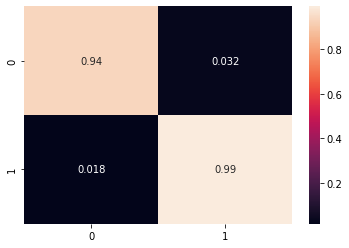

In [95]:
sample_size=500
test_size=38000
accuracy,f1,cond_met=test_evaluate(priv_data,sample_size,best_model,test_size,device='cpu')
accuracy,f1,cond_met

##Prediction Time

In [109]:
model=model.to(device_gpu)
sample_size=1000
starting_point=150

#PREDICTION 
t1=time.time()

input=priv_data[starting_point:starting_point+sample_size,:4]
input=torch.from_numpy(input).double().to(device_gpu)
input=input[::int(sample_size/150)]

pred='Faulty' if model(input)[0].item()<0.5 else 'Healthy'  #Class Predict
print("Predicted Class: ",pred)

t2=time.time()

#Display time taken in prediction
t_mil=(t2-t1)*1000
print("\nTIME TAKEN by the Model to predict the given sample size of",sample_size)
print("%.2f miliseconds" % t_mil)

Predicted Class:  Healthy

TIME TAKEN by the Model to predict the given sample size of 1000
7.93 miliseconds
